# Usage Clarification

In [70]:
import shapely.geometry
import geopandas
import starepandas

## How does use_convex and force_ccw work?
Let's 
- create a single polygon from a single ring and then
- create a gdf with this single polygon
- and then create a sdf from the gdf

In [102]:
lons = [+179.000, -179.000, -179.000, +179.000]
lats = [ +44.000,  +44.000,  +46.000, +46.000]
q_lev = 11

verts = list(zip(lons, lats))
poly = shapely.geometry.Polygon(verts)
gdf = geopandas.GeoDataFrame(crs='4326', geometry=[poly])

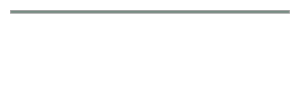

In [103]:
poly

In [132]:
import pystare

ring = poly.exterior
ring = shapely.geometry.LinearRing(ring.coords[::-1])
latlon = ring.coords.xy
sids = pystare.cover_from_ring(latlon[1], latlon[0], level=11)
sids.shape

(354,)

In [133]:
lons

[179.0, -179.0, -179.0, 179.0]

In [105]:
sdf = starepandas.STAREDataFrame(gdf, add_sids=True, level=q_lev)

In [106]:
sdf.sids.iloc[0].shape

(354,)

<Axes: >

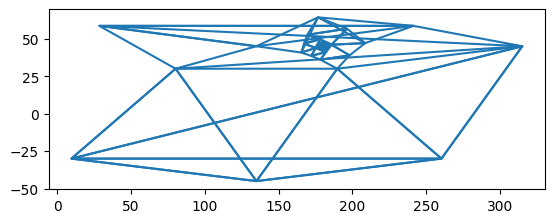

In [113]:
trixels = sdf.make_trixels(wrap_lon=False)
sdf.set_trixels(trixels, inplace=True)
#sdf.split_antimeridian()
sdf.plot()

In [129]:
sdf = starepandas.STAREDataFrame(gdf)
sids = b_sdf.make_sids(level=q_lev, convex=False, force_ccw=False)
sdf.set_sids(sids, inplace=True)

In [130]:
sids.iloc[0].shape

(628,)

Why do these yield different results?

The STAREDataFrame constructor does not give us the full ability to configure the creation of the sids. Default values are used instead. I.e. `convex=False` and `force_ccw=True`.
- `convex=False` means we are computing the SIDs for the actual exterior ring, not for it's convex hull
- `force_ccw=True` ensures that the exterior ring is counterclockwise and the interior rings clockwise. Unfortunately, this is a bit of a [clusterfuck](https://gis.stackexchange.com/questions/119150/order-of-polygon-vertices-in-general-gis-clockwise-or-counterclockwise.). We use the OGC definition. I.e. we need exterior rings to be CCW.

The polygon we defined is clockwise. The STAREDataFrame by default reverses the order to make it ccw making the ring the outer bound. in our `make_sids` call, we do not force ccw, making the ring the inner bound. I.e. the SIDs correspond to trixels covering everything on earth except the polygon.

Note: In addition, we get this exact result changing from starepandas.tools.sids_from_polygon to either starepandas.tools.sids_from_gdf or pystare.cover_from_ring.
On the whole, I’m unsure as to why there are so many options, or when to use one over the other, or why add_sids doesn’t give the same results as calling a_sdf.make_sids() or
starepandas.tools.sids_from_polygon. It seems to me given the title STAREPandas that I should prefer dataframe operations like add_sids or a_sdf.make_sids over calling extra-df methods like
starepandas.tools.sids_from_polygon.

In [62]:
cover_stare_dissolve = sdf.stare_dissolve()

In [68]:
sdf['cover'] = [cover_stare_dissolve]

In [69]:
sdf.sids.iloc[0].shape

(352,)

In [ ]:
a_sdf['cover'] = [cover_stare_dissolve]

cover_stare_dissolve = b_sdf.stare_dissolve()
b_sdf['cover'] = [cover_stare_dissolve]

In [ ]:
import os
import pickle
import math
from matplotlib import cm
from matplotlib import font_manager
import matplotlib as mpl
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, FixedLocator, MultipleLocator
from shapely.geometry import Polygon, Point, MultiPolygon
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import pandas
import geopandas

# STARE Imports
import pystare
import starepandas
import starepandas.tools.spatial_conversions
import starepandas.tools.trixel_conversions

In [ ]:
TEST_NAMES = ("q_lev", "lon_0_global", "lat_0_global", "proj_title", "make_convex_concave", 
              "make_convex", "make_concave", "has_pole", "just_east", "just_west", "use_multipoly", 
              "make_cover", "from_pnts", "wrap_lon", "use_convex", "force_ccw", "many_poly")

###############################################################################
# PUBLIC LON_180()
# ----------------
def LON_180(x): return ((x + 180.0) % 360.0) - 180.0

###############################################################################
# PUBLIC LON_360()
# ----------------
def LON_360(x): return ((x + 360.0) % 360.0)

###############################################################################
# PRIVATE check_crossing__()
# -------------------------
def check_crossing__(lon1: float, lon2: float, validate: bool = False, dlon_threshold: float = 180.0):
    """
    Assuming a minimum travel distance between two provided longitude coordinates,
    checks if the 180th meridian (antimeridian) is crossed.
    """
    if validate and any([abs(x) > 180.0 for x in [lon1, lon2]]):
        raise ValueError("longitudes must be in degrees [-180.0, 180.0]")   
    return abs(lon2 - lon1) > dlon_threshold

###############################################################################
# PRIVATE deal_with_multipoly__()
# -------------------------------
def deal_with_multipoly__(lons, lats):
    mpolys = []
    mpolys_360 = []
    mmpolys = []
    mmpolys_360 = []   
    mverts = []
    mverts_360 = []
    lon_offsets = [0.0, 45.0, 90.0, 135.0, 180.0, -135.0, -90.0, -45.0]
    # lat_offsets = [0.0, 5.0, -5.0, 0.0, 5.0, -5.0, 0.0, 5.0]
    lat_offsets = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    n_mpolys = len(lon_offsets)
    nlons = len(lons)
    for idx_ in range(n_mpolys):
        # if idx_ == 4:
        #     continue
        o_lons = [LON_360(lons[_]) + lon_offsets[idx_] for _ in range(nlons)]
        o_lons = [(o_lons[_] if o_lons[_] < 360 else 360 - o_lons[_]) for _ in range(nlons)]
        o_lons = [LON_180(_) for _ in o_lons]
        if idx_ == 4:
            o_lons = [-1.0, 0.0, 1.0, 1.0, 1.0, 0.0, -1.0, -1.0, -1.0]
        o_lons_360 = [LON_360(_) for _ in o_lons]
        o_lats = [lats[_] + lat_offsets[idx_] for _ in range(nlons)]
        o_verts = list(zip(o_lons, o_lats))
        o_verts_360 = list(zip(o_lons_360, o_lats))
        mpolys.append(Polygon(o_verts))
        mpolys_360.append(Polygon(o_verts_360))
        mverts.append(o_verts)
        mverts_360.append(o_verts_360)
        print(f"\nPoly{idx_}: Lon Offset: {lon_offsets[idx_]:+8.3f} Lat Offset: {lat_offsets[idx_]:+8.3f}")
        # for i_, val in enumerate(o_verts):
        #     print(f"{i_:2d} {val[0]:8.3f} {o_verts_360[i_][0]:8.3f} {val[1]:8.3f}")

        crosses = []
        for coord_index, lon in enumerate(o_lons[1:], start=1):
            lon_prev = o_lons[coord_index - 1]
            cross = check_crossing__(lon, lon_prev, validate=True)
            crosses.append(cross)
            # print(f"{i_:2d} {lon:8.3f} {LON_360(lon):8.3f} {o_lats[coord_index]:8.3f} {cross!r:^5}")
            # dlon = val[0] - lon_prev
            # direction = math.copysign(1, dlon)
            # print(f"{coord_index:2d}: {lon:8.3f} {lon_prev:8.3f} {cross!r:^5} {dlon:8.3f} {direction:+1.0f}")     
        crosses_dateline = any(crosses)
        print(f"{crosses_dateline = }")
        
        ##
        # Split dateline
        lons_e_idx = [_ for _ in range(nlons) if o_lons[_] <= 0.0]
        lons_w_idx = [_ for _ in range(nlons) if _ not in lons_e_idx or o_lons[_] == -180.0]
        # print(f"{lons_e_idx = }")
        # print(f"{lons_w_idx = }")

        # crosses_dateline = mpolys[-1].contains(dateline)
        # print(f"{crosses_dateline = }")
        # crosses_dateline = mpolys_360[-1].contains(dateline_360)
        # print(f"{crosses_dateline = }")        

        # lons_e_idx = [_ for _ in range(nlons) if o_lons_360[_] <= 180.0]
        # lons_w_idx = [_ for _ in range(nlons) if _ not in lons_e_idx]
        # print(f"{lons_e_idx = }")
        # print(f"{lons_w_idx = }")
        # # crosses_dateline = True if any(o_lons[_] < 180.0 for _ in range(nlons)) else False

        # if lons_e_idx and lons_w_idx:
        if crosses_dateline:
            # Split needed
            lons_e = [o_lons[_] for _ in lons_e_idx]
            lats_e = [o_lats[_] for _ in lons_e_idx]
            # if lons_e_idx:
            #     lons_e.extend([lons_e[-1], lons_e[-1]])
            #     lats_e.extend([lats_e[-1] - 1 - _ for _ in range(2)])
            lons_w = [abs(o_lons[_]) for _ in lons_w_idx]
            lats_w = [o_lats[_] for _ in lons_w_idx]

            lons_e = tuple(lons_e)
            lats_e = tuple(lats_e)
            lons_w = tuple(lons_w)
            lats_w = tuple(lats_w)

            # print(f"lons_e ({len(lons_e)}): {lons_e}")
            # print(f"lons_w ({len(lons_w)}): {lons_w}")
            # print(f"lons_e + lons_e = {len(lons_e) + len(lons_w)}")
           
            # print(f"lats_e ({len(lats_e)}): {lats_e}")
            # print(f"lats_w ({len(lats_w)}): {lats_w}")
            # print(f"lats_e + lats_e = {len(lats_e) + len(lats_w)}")

            verts_e = list(zip(lons_e, lats_e))
            verts_w = list(zip(lons_w, lats_w))
            verts_360 = list(zip([LON_360(_) for _ in lons], lats))
            verts_e_360 = list(zip([LON_360(_) for _ in lons_e], lats_e))
            verts_w_360 = list(zip([LON_360(_) for _ in lons_w], lats_w))

            poly_e = Polygon(verts_e)
            poly_w = Polygon(verts_w)

            # tmp_ = list(poly_e.exterior.coords)
            # print(f"poly_e:")
            # for i_, val in enumerate(tmp_):
            #     print(f"{i_:2d} {val[0]:8.3f} {o_verts_360[i_][0]:8.3f} {val[1]:8.3f}")
            # tmp_ = list(poly_w.exterior.coords)
            # print(f"poly_w:")
            # for i_, val in enumerate(tmp_):
            #     print(f"{i_:2d} {val[0]:8.3f} {o_verts_360[i_][0]:8.3f} {val[1]:8.3f}")
                        
            mmpolys.append(MultiPolygon([poly_w, poly_e]))
            mmpolys_360.append(MultiPolygon([Polygon(verts_w_360), Polygon(verts_e_360)]))
        else:
            mmpolys.append(Polygon(o_verts))
            mmpolys_360.append(Polygon(o_verts_360))
  
        # poly_e = Polygon(verts_e)
        # poly_w = Polygon(verts_w)
        # mmpolys.append(MultiPolygon([poly_w, poly_e]))
        # mmpolys_360.append(MultiPolygon([Polygon(verts_w_360), Polygon(verts_e_360)]))
    # print(mmpolys)

    return mpolys, mpolys_360, mmpolys, mmpolys_360

###############################################################################
# PRIVATE printable_list__()
# --------------------------
def printable_list__(a_list, a_fmt):
    if isinstance(a_list[0], list) or isinstance(a_list[0], tuple):
        return ", ".join([f"({_[0]:{a_fmt}}, {_[1]:{a_fmt}})" for _ in a_list])
    return ", ".join([f"{_:{a_fmt}}" for _ in a_list])

###############################################################################
# PRIVATE set_map__()
# -------------------
def set_map__(lon_0_global, lat_0_global, proj_title, has_pole, many_poly):
    # WGS-84 Earth equatorial radius at sea level (meters)
    #   STARE uses ccrs.Globe(datum='WGS84', ellipse='WGS84') https://epsg.io/4326
    globe = ccrs.Globe(datum='WGS84', ellipse='WGS84')

    ##
    #
    # Note: The PlateCarree projection works in the forward range of -180 to 180.
    #       Thus, the projection is always centered on the Prime Meridian (0 longitude).
    #       If you set lon_0_global = 180 and use a PlateCarree projection the data will
    #       correctly be centered on longitude 180, but the longitude labels will suggest
    #       that the dateline (lon=180) is the zero point, because it is for the PlateCarree projection.
    #   See: https://stackoverflow.com/questions/13856123/setting-up-a-map-which-crosses-the-dateline-in-cartopy


    ##
    # Utility CRS

    # Geodetic:
    #   A 3D/spherical CRS based on latitude and longitude where geographical distance and coordinates are measured in degrees.
    geod_crs = ccrs.Geodetic(globe=globe)

    # PlateCarree Projection (AKA Equirectangular or Equidistant Cylindrical):
    #   A 2D CRS with a flat topology and Euclidean distance (m).
    # flat_crs = ccrs.PlateCarree(central_longitude=lon_0_global, globe=globe)
    flat_crs = ccrs.PlateCarree(globe=globe)

    ##
    # Main Map CRS

    if proj_title == "PlateCarree":
        # PlateCarree Projection (AKA Equirectangular or Equidistant Cylindrical):
        #   A 2D CRS with a flat topology and Euclidean distance (m).
        map_crs = ccrs.PlateCarree(central_longitude=lon_0_global, globe=globe)
    elif proj_title == "LambertAzimuthalEqualArea":
        # Lambert Azimuthal Equal-Area
        #   A 2D CRS centered on (map_lat0, map_lon0), which is then the zero point of the flat topology w/ Euclidean distance (m).
        map_crs = ccrs.LambertAzimuthalEqualArea(central_longitude=lon_0_global, central_latitude=lat_0_global, globe=globe)
    if many_poly or proj_title == "NorthPolarStereo":
        map_crs = ccrs.NorthPolarStereo(central_longitude=lon_0_global, globe=globe)
        # map_crs = ccrs.LambertAzimuthalEqualArea(central_longitude=lon_0_global, central_latitude=lat_0_global, globe=globe)
        # map_crs = ccrs.PlateCarree(central_longitude=lon_0_global, globe=globe)
        
    # Tweak CRS
    map_crs._threshold /= 100.

    ##
    # Map extent
    min_lat, max_lat = 43, 47
    min_lon, max_lon = lon_0_global - 2, lon_0_global + 2
    # if proj_title == "LambertAzimuthalEqualArea":
    if has_pole:
        min_lat, max_lat = 85, 90
        min_lon, max_lon = -180, 180
    if many_poly:
        min_lat, max_lat = 35, 90
        min_lon, max_lon = -180, 180
        # min_lat, max_lat = 43, 47
        # min_lon, max_lon = -2, 2        

    # Determine the map extent (left_lon, right_lon, lower_lat, upper_lat) for the plot domain
    map_extent = (min_lon, max_lon, min_lat, max_lat)

    return globe, map_extent, geod_crs, flat_crs, map_crs

###############################################################################
# PRIVATE make_sq__()
# -------------------
def make_sq__(make_convex_concave, make_convex, make_concave, has_pole, just_east, just_west, lon_0_global):

    ##
    # Corners of the Square
    #   (min_lon, max_lon, min_lat, max_lat)
    if abs(lon_0_global) == 180:
        corners_360 = (179.0, 181.0, 44.0, 46.0)
    else:
        corners_360 = (-1.0, 1.0, 44.0, 46.0)
    corners_180 = tuple([LON_180(_) for _ in corners_360])

    ##
    # Edges of the Square
    #   (min_lon, min_lat) to (max_lon, min_lat)
    box_lons = [corners_360[0] + _ for _ in range(3)]
    box_lats = [corners_360[2] for _ in range(3)]
    #   (max_lon, min_lat) to (max_lon, max_lat)
    box_lons.extend([corners_360[1] for _ in range(2)])
    box_lats.extend([corners_360[2] + 1 + _  for _ in range(2)])
    #   (max_lon, max_lat) to (min_lon, max_lat)
    box_lons.extend([corners_360[1] - 1 - _ for _ in range(2)])
    box_lats.extend([corners_360[3] for _ in range(2)])
    #   (min_lon, max_lat) to (min_lon, min_lat)
    box_lons.extend([corners_360[0] for _ in range(2)])
    box_lats.extend([corners_360[3] - 1 - _  for _ in range(2)])

    # Clean up
    lons = tuple([LON_180(_) for _ in box_lons])
    lats = tuple(box_lats)
    nlons = len(lons)

    ##
    # Distort Square
    if make_convex_concave:
        # Distort outward and inward
        lons = list(lons)
        lats = list(lats)
        lats[1]+= 0.5
        lats[5]-= 0.5
        lons[3]-= 0.5
        lons[7]+= 0.5
    elif make_convex:
        # Distort outward
        lons = list(lons)
        lons[3]+= 0.5
        lons[7]-= 0.5
    elif make_concave:
        # Distort inward
        lons = list(lons)
        lons[3]-= 0.5
        lons[7]+= 0.5
    if has_pole:
        # Shift so has a pole
        lons_ = np.arange(0, 360 + 45, 45)
        lons = [LON_180(_) for _ in lons_.tolist()]

        lats = [85.0 for _ in range(len(lons))]
        bend_idx = [1, 3, 5, 7]
        lats = [(lats[_] + 3.0 if _ in bend_idx else lats[_]) for _ in range(len(lons))]
   
    lons = tuple(lons)
    lats = tuple(lats)

    ##
    # Split dateline
    if has_pole:
        lons_e = (0.0, 45.0, 90.0, 135.0, -180.0, -180.0, 0.0)
        lats_e = (85.0, 88.0, 85.0, 88.0, 85.0, 90.0, 85.0)
        lons_w = (-180.0, -135.0, -90.0, -45.0, 0.0, 0.0, -180.0)
        lats_w = (85.0, 88.0, 85.0, 88.0, 85.0, 90.0, 85.0) 

        lons_e = lons_e[::-1]
        lats_e = lats_e[::-1] 

    else:
        lons_e_idx = [_ for _ in range(nlons) if lons[_] <= 0.0]
        lons_w_idx = [_ for _ in range(nlons) if _ not in lons_e_idx or lons[_] == -180.0]
        lons_e = [lons[_] for _ in lons_e_idx]
        lats_e = [lats[_] for _ in lons_e_idx]
        lons_e.extend([lons_e[-1], lons_e[-1]])
        lats_e.extend([lats_e[-1] - 1 - _ for _ in range(2)])
        lons_w = [abs(lons[_]) for _ in lons_w_idx]
        lats_w = [lats[_] for _ in lons_w_idx]

        lons_e = tuple(lons_e)
        lats_e = tuple(lats_e)
        lons_w = tuple(lons_w)
        lats_w = tuple(lats_w)

    if just_east:
        # Retain just the Eastern Hemisphere
        lons = lons_e
        lats = lats_e
    elif just_west:
        # Retain just Western Hemisphere
        lons = lons_w
        lats = lats_w

    return corners_360, corners_180, lons, lats, nlons, lons_e, lats_e, lons_w, lats_w

###############################################################################
# PRIVATE make_poly__()
# ---------------------
def make_poly__(lons, lats, lons_e, lats_e, lons_w, lats_w):
    verts = list(zip(lons, lats))
    verts_e = list(zip(lons_e, lats_e))
    verts_w = list(zip(lons_w, lats_w))
    verts_360 = list(zip([LON_360(_) for _ in lons], lats))
    verts_e_360 = list(zip([LON_360(_) for _ in lons_e], lats_e))
    verts_w_360 = list(zip([LON_360(_) for _ in lons_w], lats_w))
    print(f"verts ({len(verts)}): [{printable_list__(verts, '+8.3f')}]")
    for idx_, val in enumerate(verts):
        print(f"{val[0]:8.3f} {verts_360[idx_][0]:8.3f} {val[1]:8.3f}")

    poly_e = Polygon(verts_e)
    poly_w = Polygon(verts_w)
    if use_multipoly:
        poly = MultiPolygon([poly_w, poly_e])
        poly_360 = MultiPolygon([Polygon(verts_w_360), Polygon(verts_e_360)])
    else:
        poly = Polygon(verts)
        poly_360 = Polygon(verts_360)
    print(f"\n{type(poly) = }")
    if use_multipoly:
        for idx in range(len(poly.geoms)):
            tmp_verts = list(poly.geoms[idx].exterior.coords)
            print(f"\tpoly[{idx}] ({len(tmp_verts)}) = {tmp_verts}")
            print(f"\t{poly.geoms[idx].exterior.is_closed = }")
            print(f"\t{poly.geoms[idx].exterior.is_valid = }")
            import shapely
            print(f"\t{shapely.is_valid_reason(poly.geoms[idx]) = }")

            print(f"\t{poly.geoms[idx].exterior.is_ccw = }")
            for idx_, val in enumerate(tmp_verts):
                print(f"\t\t{val[0]:8.3f} {LON_360(val[0]):8.3f} {val[1]:8.3f}")
    else:
        print(f"{poly = }")

    return verts, verts_360, poly, poly_360

###############################################################################
# PRIVATE draw_fig__()
# --------------------
def draw_fig__(the_poly, the_sdf, map_obj, proj_title, many_poly):
    draw_vert_nums = False

    (globe, map_extent, geod_crs, flat_crs, map_crs) = map_obj
    (min_lon, max_lon, min_lat, max_lat) = map_extent

    # --------------------------------------------------------------------------
    # Make Figure
    # --------------------------------------------------------------------------
    plot_dpi = 300
    plot_size = (6, 6)
    fig = plt.figure(figsize=plot_size, frameon=True)

    ##
    # Setup axes
    geo_axes = plt.axes(projection=map_crs)

    ##
    # Set Aspect Ratio
    if many_poly:
        # geo_axes.set_aspect('auto')
        x0, x1 = geo_axes.get_xlim()
        y0, y1 = geo_axes.get_ylim()
        x0 = LON_360(x0)
        x1 = LON_360(x1)
        geo_axes.set_aspect((x1 - x0) / (y1 - y0))
    else:
        x0, x1 = geo_axes.get_xlim()
        y0, y1 = geo_axes.get_ylim()
        x0 = LON_360(x0)
        x1 = LON_360(x1)
        geo_axes.set_aspect((x1 - x0) / (y1 - y0))
        
    #
    # Color Land/Sea
    # geo_axes.add_feature(cfeature.LAND, alpha=0.5)
    # geo_axes.add_feature(cfeature.COASTLINE, alpha=0.5)

    ##
    # Add gridlines
    if not many_poly:
        geo_axes.gridlines(draw_labels=True, crs=ccrs.PlateCarree())

    if many_poly:
        for pidx, a_poly in enumerate(the_poly):
            ##
            # Draw Polygon
            print(f"Polygon {pidx}: {a_poly}")
            vert_poly = geopandas.GeoDataFrame(index=[0], crs=geod_crs, geometry=[a_poly])
            vert_poly_proj = vert_poly.to_crs(map_crs)
            vert_poly_proj.plot(ax=geo_axes, kind='geo', zorder=2, facecolor='none', edgecolor='b', linewidth=1)
        if the_sdf is not None:
            for s_idx, s_row in a_sdf.iterrows():
                ##
                # Draw Trixels
                trix = starepandas.STAREDataFrame(sids=[s_row.cover], trixels=[s_row.trixels])
                trix.plot(ax=geo_axes, trixels=True, boundary=True, figsize=plot_size,
                            aspect=None, zorder=1, linewidth=0.5, color='r', alpha=0.7, transform=geod_crs)
    else:
        ##
        # Draw Polygon
        vert_poly = geopandas.GeoDataFrame(index=[0], crs=geod_crs, geometry=[the_poly])
        vert_poly_proj = vert_poly.to_crs(map_crs)
        vert_poly_proj.plot(ax=geo_axes, kind='geo', zorder=2, facecolor='none', edgecolor='b', linewidth=2)
        if the_sdf is not None:
            ##
            # Draw Trixels
            the_sdf.plot(ax=geo_axes, trixels=True, boundary=True, figsize=plot_size,
                         aspect=None, zorder=1, linewidth=0.5, color='r', alpha=0.7, transform=geod_crs)
        if draw_vert_nums:
            poly_colors = ('k', 'r', 'b')
            if hasattr(the_poly, "geoms"):
                for idx in range(len(poly.geoms)):
                    tmp_verts = list(poly.geoms[idx].exterior.coords)
                    for idx_, val in enumerate(tmp_verts):
                        print(f"\t\t{idx} {idx_} Point {val[0]:8.3f} {LON_360(val[0]):8.3f} {val[1]:8.3f}")
                        plt.text(val[0], val[1], f'{idx_}', horizontalalignment='center', color=poly_colors[idx], transform=geod_crs)
            else:
                tmp_verts = list(poly.exterior.coords)
                for idx_, val in enumerate(tmp_verts):
                    print(f"\t\t{idx_} Point {val[0]:8.3f} {LON_360(val[0]):8.3f} {val[1]:8.3f}")
                    plt.text(val[0], val[1], f'{idx_}', horizontalalignment='center', color='r', transform=geod_crs)            
    ##
    # Add gridlines
    if many_poly:
        # geo_axes.gridlines()
        geo_axes.gridlines(draw_labels=True, crs=ccrs.PlateCarree())

    geo_axes.set_extent(map_extent, crs=flat_crs)
    # if many_poly:
    #     # Compute a circle in axes coordinates, which we can use as a boundary
    #     # for the map. We can pan/zoom as much as we like - the boundary will be
    #     # permanently circular.
    #     theta = np.linspace(0, 2 * np.pi, 100)
    #     center, radius = [0.5, 0.5], 0.5
    #     verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    #     circle = mpath.Path(verts * radius + center)
    #     geo_axes.set_boundary(circle, transform=geo_axes.transAxes)

    plt.show()
    plt.clf()
    plt.close('all')


Here we set some options.

First, we set the STARE spatial resolution to use for encoding. As our example polygon is on the order of 100 km per side, a level of 11, which corresponds to a length scale of ~5 km, seems more than appropriate.

In [ ]:
q_lev = 11

Now we select our mapping options. These might be overwritten below.

In [ ]:
lon_0_global = [0.0, 180.0][1]
lat_0_global = 90.0
proj_title = ["PlateCarree", "LambertAzimuthalEqualArea"][0]

Next we set some options related to our example polygon. 

For simplicity, we can use predefined tests to set all options.

In [ ]:
##
# Test Data and settings
use_predefined_tests = [False, True][1]

if use_predefined_tests:
    # Predefined Tests
    test_title_a = "Test A: Regular Square, PlateCarree"
    test_a = (11, 180.0, 90.0, "PlateCarree", False, 
              False, False, False, False, False, False, 
              True, False, False, False, False, False)
    # test_a = (11, 0.0, 90.0, "PlateCarree", False, 
    #           False, False, False, False, False, False, 
    #           True, False, True, False, False, False)

    test_title_b = "Test B: Regular Square, LambertAzimuthalEqualArea"
    test_b = (11, 180.0, 45.0, "LambertAzimuthalEqualArea", False, 
              False, False, False, False, False, False, 
              True, False, False, False, False, False)
    
    test_title_c = "Test C: Regular Square, wrap_lon=False"
    test_c = (11, 180.0, 90.0, "PlateCarree", False, 
              False, False, False, False, False, False, 
              False, False, True, False, False, False)
    
    test_title_d = "Test D: Regular Square as Multipolygon, PlateCarree"
    test_d = (11, 180.0, 90.0, "PlateCarree", False, 
              False, False, False, False, False, True, 
              True, False, False, False, False, False)    

    test_title_e = "Test E: Stare Star, LambertAzimuthalEqualArea"
    test_e = (11, 180.0, 90.0, "LambertAzimuthalEqualArea", True, 
              False, False, False, False, False, False, 
              True, False, False, False, False, False)

    test_title_f = "Test F: Multiple Regular Square, NorthPolarStereo"
    test_f = (11, 180.0, 90.0, "NorthPolarStereo", False, 
              False, False, False, False, False, False, 
              True, False, False, False, False, True)

    # Parse Predefined Tests
    use_these = test_a
    test_title = test_title_a
    (q_lev, lon_0_global, lat_0_global, proj_title, make_convex_concave, 
     make_convex, make_concave, has_pole, just_east, just_west, use_multipoly, 
     make_cover, from_pnts, wrap_lon, use_convex, force_ccw, many_poly) = use_these
else:
    # Manually define test
    make_convex_concave = [False, True][0]
    make_convex         = [False, True][0]
    make_concave        = [False, True][0]
    has_pole            = [False, True][0]
    just_east           = [False, True][0]
    just_west           = [False, True][0]
    use_multipoly       = [False, True][0]
    # Next we set some options for STARE.
    make_cover          = [False, True][1]
    from_pnts           = [False, True][0]
    wrap_lon            = [False, True][0]
    use_convex          = [False, True][0]
    force_ccw           = [False, True][0]
    many_poly           = [False, True][0]
    use_these = (q_lev, lon_0_global, lat_0_global, proj_title, make_convex_concave, 
                 make_convex, make_concave, has_pole, just_east, just_west, use_multipoly, 
                 make_cover, from_pnts, wrap_lon, use_convex, force_ccw, many_poly)
    if many_poly and (has_pole or use_multipoly):
        raise Exception("Cannot have many_poly and has_pole")
print("Test Settings:")
if use_predefined_tests:
    print(f"\t{test_title}")
for idx_, para_ in enumerate(TEST_NAMES):
    print(f"\t\t{para_:<20s}: {use_these[idx_]}")

Now we can define a test shape (a square that straddles the Dateline).

In [ ]:
(corners_360, corners_180, lons, lats,
 nlons, lons_e, lats_e, lons_w, lats_w) = make_sq__(make_convex_concave, make_convex, make_concave, has_pole, just_east, just_west, lon_0_global)
print(f"lons ({len(lons)}): [{printable_list__(lons, '+8.3f')}]")
print(f"lats ({len(lats)}): [{printable_list__(lats, '+8.3f')}]")

Next we form vertices and polygons.

In [ ]:
verts, verts_360, poly, poly_360 = make_poly__(lons, lats, lons_e, lats_e, lons_w, lats_w)

Option for multiple polygons

In [ ]:
mpolys = None
if many_poly:
    mpolys, mpolys_360, mmpolys, mmpolys_360 = deal_with_multipoly__(lons, lats)
    draw_fig__(mmpolys, None, map_obj, proj_title, many_poly)

Now we define some geometries for working with maps. 

In [ ]:
map_obj = set_map__(lon_0_global, lat_0_global, proj_title, has_pole, many_poly)
(globe, map_extent, geod_crs, flat_crs, map_crs) = map_obj
(min_lon, max_lon, min_lat, max_lat) = map_extent
print(f"Map extent: ({min_lon = :+8.3f}, {max_lon = :+8.3f}, {min_lat = :+8.3f}, {max_lat = :+8.3f})")

draw_fig__((mpolys if mpolys is not None else poly), None, map_obj, proj_title, many_poly)


Now we can make a GeoPandas Dataframe

In [ ]:
if many_poly:
    a_gdf = geopandas.GeoDataFrame({'geometry': mpolys}, geometry='geometry', crs=geod_crs)
else:
    a_gdf = geopandas.GeoDataFrame([0], crs=geod_crs, geometry=[poly])

# a_sdf = starepandas.STAREDataFrame(a_gdf)
# sids_ = a_sdf.make_sids(level=q_lev, convex=use_convex, force_ccw=force_ccw)
# a_sdf.set_sids(sids_, inplace=True)
a_sdf = starepandas.STAREDataFrame(a_gdf, add_sids=True, level=q_lev)

sids_tmp = a_sdf.sids.tolist()[0]
print(f"\tsids_from_df at QLev-{q_lev} ({len(sids_tmp)}): [{sids_tmp[0]}, ... {sids_tmp[-1]}] or [{hex(sids_tmp[0])}, ... {hex(sids_tmp[-1])}]")

Next we encode our polygon using STARE indexes (SIDs) by passing our data as a Shapely Polygon (or MultiPolygon).

In [ ]:
if use_multipoly:
    sids_from_multipolygon = starepandas.tools.sids_from_multipolygon(poly, q_lev, convex=use_convex, force_ccw=force_ccw)
    # sids_from_multipolygon = starepandas.sids_from_multipolygon(poly, q_lev, convex=use_convex, force_ccw=force_ccw)
    print(f"Using starepandas.tools.sids_from_multipolygon w/ convex = {use_convex} and force_ccw = {force_ccw}")
    sids_tmp = sids_from_multipolygon
    print(f"\t{type(sids_from_multipolygon) = }")
    print(f"\tsids_from_multipolygon at QLev-{q_lev} ({len(sids_tmp)}): [{sids_tmp[0]}, ... {sids_tmp[-1]}] or [{hex(sids_tmp[0])}, ... {hex(sids_tmp[-1])}]")
else:
    if many_poly:
        sids_from_geodataframe = starepandas.tools.sids_from_gdf(a_gdf, level=q_lev, convex=use_convex, force_ccw=force_ccw)
        # sids_from_geodataframe = starepandas.sids_from_gdf(a_gdf, level=q_lev, convex=use_convex, force_ccw=force_ccw)
        print(f"Using starepandas.tools.sids_from_gdf w/ convex = {use_convex} and force_ccw = {force_ccw}")
    else:
        sids_from_polygon = starepandas.tools.sids_from_polygon(poly, q_lev, convex=use_convex, force_ccw=force_ccw)
        # sids_from_polygon = starepandas.sids_from_polygon(poly, q_lev, convex=use_convex, force_ccw=force_ccw)
        print(f"Using starepandas.tools.sids_from_polygon w/ convex = {use_convex} and force_ccw = {force_ccw}")
        sids_tmp = sids_from_polygon
        print(f"\t{type(sids_from_polygon) = }")
        print(f"\tsids_from_polygon at QLev-{q_lev} ({len(sids_tmp)}): [{sids_tmp[0]}, ... {sids_tmp[-1]}] or [{hex(sids_tmp[0])}, ... {hex(sids_tmp[-1])}]")

Moving on, we form a STAREPandas Dataframe

In [ ]:
if many_poly:
    b_sdf = starepandas.STAREDataFrame(a_gdf, sids=sids_from_geodataframe)
else:
    if use_multipoly:
        sids = sids_from_multipolygon
    else:
        sids = sids_from_polygon
    b_sdf = starepandas.STAREDataFrame(a_gdf, sids=[sids])

Next we will form a STARE cover.

In [ ]:
if many_poly:
    print("\nUsing starepandas.stare_dissolve")
    a_sdf['polys'] = a_sdf.index
    cover_stare_dissolve = a_sdf.stare_dissolve(by='polys', num_workers=1, geom=False, aggfunc='first')
    a_sdf['cover'] = cover_stare_dissolve["sids"].to_numpy()
    # a_sdf.drop('polys', inplace=True, axis=1)
    # print(a_sdf.info())
    # print(a_sdf.columns)
else:
    print("\nUsing starepandas.stare_dissolve")
    cover_stare_dissolve = a_sdf.stare_dissolve(by=None, num_workers=1, geom=False, aggfunc='first')
    a_sdf['cover'] = [cover_stare_dissolve]
    if len(cover_stare_dissolve) == 1:
        print(f"\tcover_stare_dissolve = {cover_stare_dissolve[0]}")
    else:
        print(f"\tcover_stare_dissolve ({len(cover_stare_dissolve)}): [{cover_stare_dissolve[0]}, ... {cover_stare_dissolve[-1]}] or [{hex(cover_stare_dissolve[0])}, ... {hex(cover_stare_dissolve[-1])}]")

    cover_stare_dissolve = b_sdf.stare_dissolve(by=None, num_workers=1, geom=False, aggfunc='first')
    b_sdf['cover'] = [cover_stare_dissolve]
    if len(cover_stare_dissolve) == 1:
        print(f"\tcover_stare_dissolve = {cover_stare_dissolve[0]}")
    else:
        print(f"\tcover_stare_dissolve ({len(cover_stare_dissolve)}): [{cover_stare_dissolve[0]}, ... {cover_stare_dissolve[-1]}] or [{hex(cover_stare_dissolve[0])}, ... {hex(cover_stare_dissolve[-1])}]")


These are very different covers in terms of SID counts. However, when converted to trixels they give the same result. Well, except for `c_sdf`.

Make STARE trixels

In [ ]:
if many_poly:
    trixels_a = a_sdf.make_trixels(wrap_lon=wrap_lon)
    a_sdf.drop('geometry', inplace=True, axis=1)
    a_sdf.set_trixels(trixels_a, inplace=True)
    # print(a_sdf.head())
    # print(a_sdf.info())
    # print(a_sdf.columns)
else:
    trixels_a = a_sdf.make_trixels(wrap_lon=wrap_lon)
    trixels_tmp = trixels_a.tolist()[0]
    if (isinstance(trixels_tmp, MultiPolygon)):
        trixels_tmp = list(trixels_tmp.geoms[0].exterior.coords)
    else:
        trixels_tmp = list(trixels_tmp.exterior.coords)
    a_sdf.drop('geometry', inplace=True, axis=1)
    a_sdf.set_trixels(trixels_a, inplace=True)
    print(f"\nUsing make_trixels: {wrap_lon = }")
    print(f"\ttrixels_a ({len(trixels_tmp)}): {trixels_tmp}")

    trixels_b = b_sdf.make_trixels(wrap_lon=wrap_lon)
    trixels_tmp = trixels_b.tolist()[0]
    if (isinstance(trixels_tmp, MultiPolygon)):
        trixels_tmp = list(trixels_tmp.geoms[0].exterior.coords)
    else:
        trixels_tmp = list(trixels_tmp.exterior.coords)
    b_sdf.drop('geometry', inplace=True, axis=1)
    b_sdf.set_trixels(trixels_b, inplace=True)
    print(f"\nUsing make_trixels: {wrap_lon = }")
    print(f"\ttrixels_b ({len(trixels_tmp)}): {trixels_tmp}")

In [ ]:
if not wrap_lon:
    print("\nUsing a_sdf.split_antimeridian")
    if many_poly:
        # Caution:
        #   There are two definitions of split_antimeridian.
        #       1) A class method called `starepandas.split_antimeridian()`.
        #           * This operates on instances of `starepandas.STAREDataFrame` and calls the other definition.
        #           * This either returns a new dataframe or modifies one in-place.
        #       2) A `starepandas.tools.trixel_conversions` package function `split_antimeridian()`.
        #           * This operates on Polygons/MultiPolygons and returns Polygons/MultiPolygons.
        # 
        #   The class method is a wrapper around the package function.
        # import inspect
        # print(inspect.getfile(starepandas.split_antimeridian))
        # print(inspect.getfile(a_sdf.split_antimeridian))
        # print(inspect.getfile(starepandas.tools.trixel_conversions.split_antimeridian))

        a_sdf.split_antimeridian(inplace=True, drop=False)
        # This give the same result
        # tmp_ = starepandas.tools.trixel_conversions.split_antimeridian(trixels_a)
        # a_sdf.set_trixels([tmp_], inplace=True)
    else:
        # print(a_sdf.head())
        # print(a_sdf.info())
        # print(a_sdf.columns)
    
        # a_sdf.split_antimeridian(inplace=True, drop=False)
        # trixels_tmp = list(a_sdf['trixels'].tolist()[0].geoms[0].exterior.coords)
        # # This give the same result
        # # tmp_ = starepandas.tools.trixel_conversions.split_antimeridian(trixels_a, drop=False)
        # # a_sdf.set_trixels([tmp_], inplace=True)
        # # trixels_tmp = list(tmp_.geoms[0].exterior.coords)
        # print(f"\ttrixels_a ({len(trixels_tmp)}): {trixels_tmp}")

        b_sdf.split_antimeridian(inplace=True, drop=False)
        trixels_tmp = list(b_sdf['trixels'].tolist()[0].geoms[0].exterior.coords)
        # This give the same result
        # tmp_ = starepandas.tools.trixel_conversions.split_antimeridian(trixels_b, drop=False)
        # b_sdf.set_trixels([tmp_], inplace=True)
        # trixels_tmp = list(tmp_.geoms[0].exterior.coords)
        print(f"\ttrixels_b ({len(trixels_tmp)}): {trixels_tmp}")

Now we can plot our results.

In [ ]:
if many_poly:
    draw_fig__(mmpolys, a_sdf, map_obj, proj_title, many_poly)
else:
    draw_fig__(poly, a_sdf, map_obj, proj_title, many_poly)

In [ ]:
if not many_poly:
    draw_fig__(poly, b_sdf, map_obj, proj_title, many_poly)